In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from tensorflow.keras import Sequential , optimizers
from tensorflow.keras.layers import Dropout,Dense,LSTM
import tensorflow as tf


# 10.1.1

In [28]:
ACC   = pd.read_csv('acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [29]:
# Check 'timedelta' max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
# หา start_timedelta, end_timedelta
HeartR_max = HeartR['timedelta'].max()
HeartR_min = HeartR['timedelta'].min()

SleepL_max = SleepL['timedelta'].max()
SleepL_min = SleepL['timedelta'].min()

print(f'ACC start: {ACC_min_date} ACC end: {ACC_max_date}')
print(f'HeartR start: {HeartR_min} HeartR end: {HeartR_max}')
print(f'SleepL start: {SleepL_min} SLeepL end: {SleepL_max}')


ACC start: -124489.16105 ACC end: 17643.046417
HeartR start: -556410.36066 HeartR end: 16980.47229
SleepL start: 0 SLeepL end: 16980


In [30]:
 # select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน) #เลือกขอบ
ACC_new = ACC[(ACC['timedelta'] > SleepL_min) & (ACC['timedelta'] < SleepL_max)]
HeartR_new = HeartR[(HeartR['timedelta']> SleepL_min) & HeartR['timedelta']< SleepL_max]
SleepL_new = SleepL[(SleepL['timedelta']> SleepL_min) & SleepL['timedelta']< SleepL_max]

In [31]:
 # Convert to datetime and round to second,
 # ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
ACC_new

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12324\2630731856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


In [32]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()
ACC = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC = ACC.loc[:,~ACC.columns.duplicated()].copy() #ตัด duplicate columns(timedelta)
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [33]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

In [34]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()

In [35]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

In [36]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2.replace({-1:0},inplace=True)

In [37]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')

In [38]:
# Fill NA
# Heart rate
# Fillna() # using median()
heart_mean = df.heartrate.mean()
df.heartrate.fillna(heart_mean,inplace=True)
# # Sleep Label
# Fillna() # with 0
df.sleep.fillna(0,inplace=True)
# # Drop column
df.drop(columns='timedelta',inplace=True)
df


,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,87.0,0.0
1,-0.240757,0.873826,0.415446,87.0,0.0
2,-0.244620,0.883943,0.387026,87.0,0.0
3,-0.248036,0.902427,0.347812,87.0,0.0
4,-0.241778,0.912946,0.321502,87.0,0.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.0,0.0
16977,-0.441990,-0.525476,0.723410,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


# 10.1.2 SMA

In [39]:
# # ------------Simple Moving Average (SMA) ------------------------------ SMA 5                  
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df[feature_columns]
df_feature_SMA = pd.DataFrame()
df_feature_SMA['accX']      =    df_feature['accX'].rolling(5, min_periods=1).mean()    # min_period กันติดค่า NA
df_feature_SMA['accY']      =    df_feature['accY'].rolling(5, min_periods=1).mean()
df_feature_SMA['accZ']      =    df_feature['accZ'].rolling(5, min_periods=1).mean()
df_feature_SMA['heartrate'] =    df_feature['heartrate'].rolling(5, min_periods=1).mean()


In [40]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df_feature_SMA[feature_columns])

df_feature = df[feature_columns]
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.589117,3.071108,0.699695,0.794356
1,-0.586064,3.039478,0.729243,0.794356
2,-0.588261,3.038837,0.727393,0.794356
3,-0.591491,3.052083,0.714363,0.794356
4,-0.590305,3.066209,0.700046,0.794356
...,...,...,...,...
16976,-1.085938,-1.101418,1.139230,-0.713978
16977,-1.085722,-1.101129,1.139208,-0.687973
16978,-1.085465,-1.100774,1.139306,-0.661967
16979,-1.085825,-1.101020,1.139113,-0.635961


In [41]:
# ------------ Train-Test-Split 2D features -------------------------------
# set sliding window parameter
slidingW = 100 #จ ํานวน row
stride_step = 5
df_feature2D = []
df_feature2D_T = []
df_label_new = np.array([])
for t in range( 0 , len(df_label) - 96, stride_step ):
    F2d = df_feature[t : t + slidingW]
    df_feature2D.append(np.array(F2d))
    F2d_T = np.transpose(F2d)
    df_feature2D_T.append(np.array(F2d_T))

    Labels = stats.mode(df_label[t:t+slidingW ])
    
    df_label_new = np.append(df_label_new,Labels[0])

#df_label_new = df_label_new.reshape(len(df_label_new),1)

df_feature2D = np.array(df_feature2D)
df_feature2D_T = np.array(df_feature2D_T)

print(np.array(df_feature2D).shape)
print(np.array(df_feature2D_T).shape)
#print(np.array(np.transpose(df_feature2D_T)).shape)
print(df_label_new.shape)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12324\4083850837.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Labels = stats.mode(df_label[t:t+slidingW ])


(3377, 100, 4)
(3377, 4, 100)
(3377,)


In [42]:
# print(df_feature2D)
print(df_label_new[0])

0.0


# 10.1.3 Train Test Split 

In [43]:
# ------------ Train-Test-Split 2D features -------------------------------
# x_train, x_test, y_train, y_test = train_test_split( df_feature2D, df_label_new)

In [44]:
# # ------------ Train-Test-Split 2D features -------------------------------
x_train, x_test, y_train, y_test = train_test_split( df_feature2D_T, df_label_new)

# 10.2 LSTM Model

In [45]:
# try
#Option #1:
inRow = N_features = len(df_label_new)
inCol = Sliding_windows = 100
# # Option #2
# inRow = Sliding_windows 
# inCol = N_features

# #1: no transpose
# input_shape=(timesteps, n_features)

# #2: with transpose
# input_shape=(n_features,timesteps)

# ------------ LSTM Architecture parameter -------------------------------
LSTM_L1 = 200 # try 200, 300, 400, 500, 1000 
LSTM_L2 = 100 # try 50, 100, 150, 200, 250, 300
dropRate_L1 = 0.25
dropRate_L2 = 0.5
Activation = 'Softmax'
n_classes = 6  # จำนวน class ของคำตอบ
Input_shape = (x_train.shape[1], x_train.shape[2])
Input_shape

(4, 100)

In [46]:
# ------------ Create LSTM Model -------------------------------
model = Sequential()
model.add(LSTM(LSTM_L1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(dropRate_L1 ))
model.add(LSTM(LSTM_L2 ))
model.add(Dropout(dropRate_L2))
model.add(Dense(n_classes, activation='softmax'))
# model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 200)            240800    
                                                                 
 dropout_2 (Dropout)         (None, 4, 200)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               120400    
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 361,806
Trainable params: 361,806
Non-trainable params: 0
_________________________________________________________________


In [47]:
 # ------------ Create Optimizer -------------------------------
model.compile( optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["acc"])

In [48]:
# Training the model

# Option#1: no transpose
# input_shape=(timesteps, n_features)

# Option#2: with transpose
# input_shape=( n_features, timesteps)

EP = 100
batch_size = 100 # try 20, 40, 60, 80, 100 (iteration)
history = model.fit(x_train, y_train, batch_size = batch_size, validation_data=(x_test, y_test), epochs=EP)

Epoch 1/100
26/26 [==============================] - 3s 37ms/step - loss: 1.3087 - acc: 0.4953 - val_loss: 1.0304 - val_acc: 0.5266
Epoch 2/100
26/26 [==============================] - 0s 18ms/step - loss: 0.9969 - acc: 0.5873 - val_loss: 0.8478 - val_acc: 0.6320
Epoch 3/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7984 - acc: 0.6951 - val_loss: 0.6449 - val_acc: 0.7385
Epoch 4/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6599 - acc: 0.7461 - val_loss: 0.5262 - val_acc: 0.8118
Epoch 5/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5599 - acc: 0.7788 - val_loss: 0.4666 - val_acc: 0.8166
Epoch 6/100
26/26 [==============================] - 0s 17ms/step - loss: 0.4834 - acc: 0.8128 - val_loss: 0.3959 - val_acc: 0.8651
Epoch 7/100
26/26 [==============================] - 0s 19ms/step - loss: 0.4271 - acc: 0.8262 - val_loss: 0.3933 - val_acc: 0.8237
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 0.

# 10.3 Performnace of LSTM Model

In [49]:
#LSTM prediction for Option #1 and Option #2
LSTM_pred = model.predict(x_test)
#Get classID from max prob(LSTM_pred)
df_pred = pd.DataFrame(LSTM_pred)
#df_class => use dataframe -> idxmax(axis=1)

LSTM_pred = np.argmax(model.predict(x_test),axis=1)
df_pred

27/27 [==============================] - 0s 2ms/step


,0,1,2,3,4,5
0,6.241620e-02,3.224017e-04,0.934866,0.002253,5.655480e-06,1.366229e-04
1,4.800210e-06,1.666333e-08,0.000008,0.999987,4.729989e-07,2.868566e-07
2,5.183161e-07,6.295652e-08,0.000012,0.000001,1.041890e-06,9.999852e-01
3,4.167900e-06,1.736303e-06,0.005584,0.994407,2.631609e-06,4.698283e-07
4,1.261497e-05,4.482641e-08,0.000005,0.999980,1.235528e-06,9.775608e-07
...,...,...,...,...,...,...
840,1.221111e-06,5.116920e-07,0.000805,0.999193,9.678356e-07,7.651615e-08
841,7.309435e-06,3.456185e-08,0.000006,0.999985,9.134358e-07,7.108264e-07
842,2.497071e-06,1.255587e-08,0.000017,0.999980,2.707252e-07,2.084872e-07
843,9.999791e-01,1.984145e-06,0.000009,0.000010,2.344588e-08,3.551092e-07


In [50]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
print('----- Confusion matrix of LSTM -----')
print(confusion_matrix(y_test,LSTM_pred))
print('----- Classification matrix of LSTM -----')
print(classification_report(y_test,LSTM_pred))

----- Confusion matrix of LSTM -----
[[132   5   4   1   0]
 [  0  44   8   0   0]
 [  2   2 245  14   3]
 [  0   0   0 217   0]
 [  0   1   5   0 162]]
----- Classification matrix of LSTM -----
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       142
         1.0       0.85      0.85      0.85        52
         2.0       0.94      0.92      0.93       266
         3.0       0.94      1.00      0.97       217
         5.0       0.98      0.96      0.97       168

    accuracy                           0.95       845
   macro avg       0.94      0.93      0.93       845
weighted avg       0.95      0.95      0.95       845



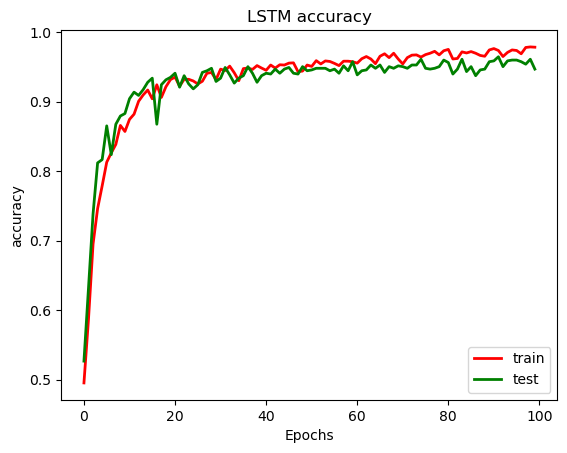

In [51]:
plt.plot(history.history['acc'],'r',linewidth=2,label ='train')
plt.plot(history.history['val_acc'],'g',linewidth =2 , label = 'test')
plt.title('LSTM accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

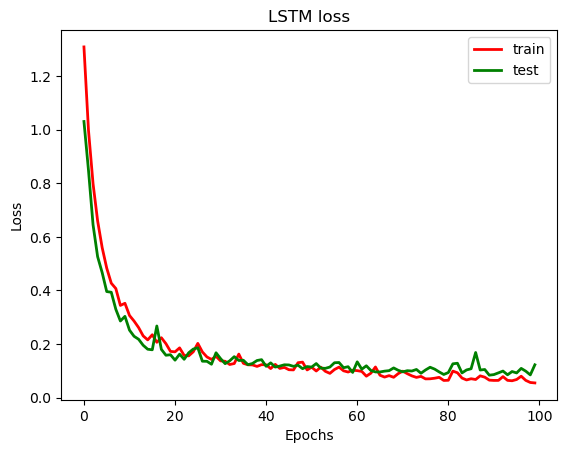

In [52]:
# # ------ View History Graph -------------------------------------------
# # View Accuracy Graph, Loss Graph
plt.plot(history.history['loss'],'r',linewidth=2,label ='train')
plt.plot(history.history['val_loss'],'g',linewidth =2 , label = 'test')
plt.title('LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()